# DATASET DOWNLOAD


In [1]:
!pip install -q sentence_transformers
!pip install -q lxml


# Reading files

In [2]:
from pathlib import Path
from bs4 import BeautifulSoup

def html_to_text(path: Path, max_words=1500) -> dict:
    html = path.read_text(encoding="utf-8", errors="ignore")
    soup = BeautifulSoup(html, "lxml")

    for tag in soup(["script", "style", "noscript"]):
        tag.decompose()

    title = soup.title.get_text(" ", strip=True) if soup.title else path.stem
    text = soup.get_text(separator=" ", strip=True)

    text = " ".join(text.split()[:max_words])  # 🔥 TAGLIO

    return {"id": path.name, "title": title, "text": text}


files = list(Path(r"adm-2025-unsupervised-book-grouping\pages").glob("*.html"))
docs = [html_to_text(p) for p in files]
texts = [d["title"] + "\n" + d["text"] for d in docs]


# Vectorizing by semantic

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
X = model.encode(texts, normalize_embeddings=True, show_progress_bar=True)



c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 61/61 [00:37<00:00,  1.62it/s]


# Clustering

c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: User

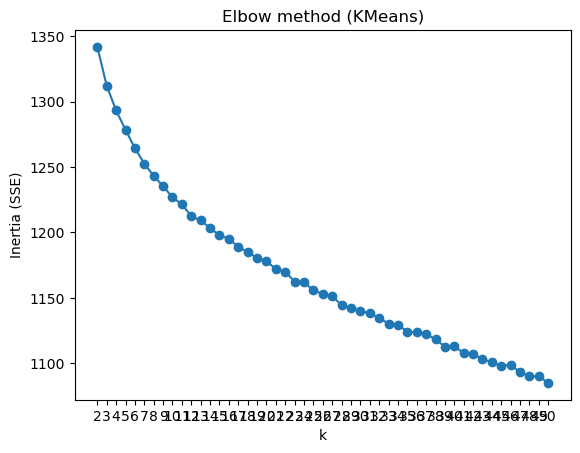

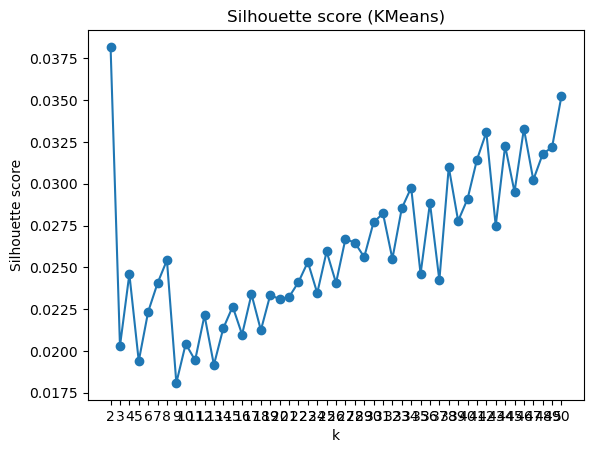

Best k (silhouette): 2


In [17]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
def kmeans_elbow_silhouette(
    X,
    k_min=2,
    k_max=30,
    random_state=42,
    n_init=10,
    sample_size_for_silhouette=None,  # es. 2000 se dataset enorme
):
    """
    Calcola inertia (elbow) e silhouette score per K in [k_min, k_max].
    Ritorna: ks, inertias, silhouettes
    """
    n_samples = X.shape[0]
    if n_samples < 3:
        raise ValueError("Servono almeno 3 campioni per usare silhouette in modo sensato.")

    k_max = min(k_max, n_samples - 1)
    ks = list(range(k_min, k_max + 1))

    inertias = []
    silhouettes = []

    for k in ks:
        km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)

        # silhouette richiede almeno 2 cluster e < n_samples
        # (qui k>=2 e k<=n_samples-1 già garantito)
        if sample_size_for_silhouette is not None and n_samples > sample_size_for_silhouette:
            sil = silhouette_score(X, labels, sample_size=sample_size_for_silhouette, random_state=random_state)
        else:
            sil = silhouette_score(X, labels)
        silhouettes.append(sil)

    return np.array(ks), np.array(inertias), np.array(silhouettes)


# --- USO ---
# X può essere:
# - embeddings: X_emb (shape: n_libri, 384) -> numpy array
# - TF-IDF: X_tfidf (shape: n_libri, n_features) -> sparse matrix

ks, inertias, sils = kmeans_elbow_silhouette(
    X,                 # <-- metti qui la tua matrice (X_emb o X_tfidf)
    k_min=2,
    k_max=50,
    random_state=42,
    n_init=10,
    sample_size_for_silhouette=None  # oppure 2000 se hai dataset molto grande
)

# --- PLOT ELBOW ---
plt.figure()
plt.plot(ks, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow method (KMeans)")
plt.xticks(ks)
plt.show()

# --- PLOT SILHOUETTE ---
plt.figure()
plt.plot(ks, sils, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette score (KMeans)")
plt.xticks(ks)
plt.show()

# --- k suggerito ---
best_k = int(ks[np.argmax(sils)])
print("Best k (silhouette):", best_k)

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=150, random_state=42)
X_pca = pca.fit_transform(X)

print("Varianza cumulativa:", pca.explained_variance_ratio_.sum())


Varianza cumulativa: 0.8791102


In [29]:
X=X_pca

In [30]:
from sklearn.cluster import KMeans

k = 8
labels = KMeans(n_clusters=k, n_init="auto", random_state=42).fit_predict(X)


c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [33]:
from sklearn.mixture import GaussianMixture
k=8
gmm = GaussianMixture(
    n_components=k,
    covariance_type="full",   # più flessibile (default)
    n_init=5,
    random_state=42
)

labels = gmm.fit_predict(X)

c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: User

# Clusters

In [34]:
import numpy as np
from collections import defaultdict

# se hai usato TF-IDF: X è sparse, vectorizer esiste
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(texts)
feature_names = np.array(vectorizer.get_feature_names_out())

cluster_top_terms = {}
for c in sorted(set(labels)):
    idx = np.where(labels == c)[0]
    centroid = X_tfidf[idx].mean(axis=0)              # (1, n_features)
    top = np.asarray(centroid).ravel().argsort()[-10:][::-1]
    cluster_top_terms[c] = feature_names[top].tolist()

cluster_top_terms

{np.int64(0): ['how',
  'how to',
  'life',
  'habits',
  'we',
  'he',
  'power',
  'his',
  'guide',
  'our'],
 np.int64(1): ['war',
  'his',
  'he',
  'vietnam',
  'world war',
  'the war',
  'hardcover',
  'american',
  'story',
  'and the'],
 np.int64(2): ['her',
  'she',
  'series',
  'magic',
  'he',
  'me',
  'hardcover',
  'his',
  'love',
  'they'],
 np.int64(3): ['her',
  'he',
  'she',
  'his',
  'reacher',
  'me',
  'series',
  'love',
  'jack',
  '2013'],
 np.int64(4): ['shakespeare',
  'his',
  'plays',
  'he',
  'play',
  'william shakespeare',
  'of shakespeare',
  'william',
  'works',
  'wilde'],
 np.int64(5): ['vampire',
  'her',
  'she',
  'series',
  '2010',
  'anita',
  'he',
  '2011',
  'vampires',
  '2009'],
 np.int64(6): ['he',
  'his',
  'series',
  'rebus',
  'christie',
  'holmes',
  'harry',
  'sherlock',
  'bosch',
  'sherlock holmes'],
 np.int64(7): ['her',
  'she',
  'he',
  'love',
  'me',
  'his',
  'just',
  'they',
  '2013',
  'story']}

In [35]:
!pip install -q pandas

In [36]:
import pandas as pd

rows = []
for i, d in enumerate(docs):
    rows.append({
        "ID": i,
        "TARGET": int(labels[i])
    })

df = pd.DataFrame(rows)
df.to_csv("book_clusters.csv", index=False, encoding="utf-8")

df.head()

,ID,TARGET
0,0,6
1,1,5
2,2,3
3,3,7
4,4,0
